
### **1. Data Cleaning**


**1. Importing Libraries**
The code starts by importing necessary libraries for the tasks:

**PySpark:** Used for distributed data processing. It handles DataFrame manipulation and UDF registration.

**NumPy:** Handles numerical operations, particularly for decoding images.

**Matplotlib:** Used for visualizing data through plots.

**OpenCV:** Decodes image bytes into NumPy arrays.

**PyTorch:** Determines GPU availability and enhances computation using CUDA or MPS.

**OS:** Manages file paths across operating systems.

In [4]:
# Importing libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, sum as _sum
from pyspark.sql.types import ArrayType, IntegerType
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import os

ModuleNotFoundError: No module named 'cv2'

**2. Constants Definition**

In [ ]:
# Constants
BASE_DIR = r"/Users/ivantravisany/Documents/Estudios/git/medical-image-diagnosis-with-cnn/dataset/"
TRAIN_FILE = "train-00000-of-00001-c08a401c53fe5312.parquet"
TEST_FILE = "test-00000-of-00001-44110b9df98c5585.parquet"
LABELS = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}


**3. Decoding Images**

**The decode_image function:** Takes byte-encoded images and converts them into grayscale. Flattens the image into a 1D array for efficient storage. This function is registered as a PySpark UDF (decode_image_udf) for parallel processing on Spark DataFrames.

In [ ]:
# Function to decode images from byte dictionaries
def decode_image(image_bytes):
    """
    Decodes an image stored as bytes to a grayscale NumPy array.

    Args:
        image_bytes (bytes): Encoded image data as bytes.

    Returns:
        list: Flattened grayscale image as a list.
    """
    if image_bytes is None:
        return None
    nparr = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
    return img.flatten().tolist() if img is not None else None

# Register UDF for decoding images
decode_image_udf = udf(decode_image, ArrayType(IntegerType()))

**4. Initializing Spark Session and GPU Optimization**

**PyTorch is used to check for GPU availability:**

**CUDA:** If available, computations will run on NVIDIA GPUs.

**MPS:** Support for Apple Silicon devices.

**CPU:** Used as a fallback if no GPUs are available.

In [ ]:
# Initialize Spark Session with necessary configurations for local file paths
spark = SparkSession.builder \
    .appName("Medical Image Diagnosis") \
    .getOrCreate()

# Enable GPU optimizations if available
torch.backends.cudnn.benchmark = True

# Determine the best available device (CUDA, MPS, or CPU)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


**5. Preprocessing Datasets**

**The preprocess_dataset function:** Reads a Parquet file into a Spark DataFrame. Decodes the image.bytes column using the UDF and stores the results in a new column img_arr. And displays a preview of the dataset before and after decoding.

In [ ]:
# Load and preprocess the dataset
def preprocess_dataset(file_path):
    """
    Loads and preprocesses the dataset by decoding images and dropping unused columns.

    Args:
        file_path (str): Path to the Parquet file.

    Returns:
        pyspark.sql.DataFrame: Preprocessed DataFrame with decoded images.
    """
    # Load dataset into a Spark DataFrame
    df = spark.read.parquet(file_path)

    # Show a sample of the data without decoding the images
    print("Training data without decoding images:")
    df.limit(5).show()

    # Decode the 'image' column
    df = df.withColumn("img_arr", decode_image_udf(col("image.bytes")))

    return df


In [ ]:
# Fix the file path by joining the BASE_DIR and TRAIN_FILE correctly
train_file_path = os.path.join(BASE_DIR, TRAIN_FILE).replace("\\", "/")

# Preprocess the training dataset
train_df = preprocess_dataset(train_file_path)

# Take a small sample of the data without triggering memory issues
sample_data = train_df.select("label", "img_arr").head(5)

# Display the sample data
print("Sample Training Data after decoding images:")
for row in sample_data:
    label = row['label']
    img_arr = row['img_arr']  # Full image array, limiting the display size
    print(f"Label: {LABELS.get(label, 'Unknown')}, Image Array (first 10 pixels): {img_arr[:10]}")  # First 10 pixels of the image

Training data without decoding images:
+--------------------+-----+
|               image|label|
+--------------------+-----+
|{[FF D8 FF E0 00 ...|    2|
|{[FF D8 FF E0 00 ...|    0|
|{[FF D8 FF E0 00 ...|    3|
|{[FF D8 FF E0 00 ...|    3|
|{[FF D8 FF E0 00 ...|    2|
+--------------------+-----+

Sample Training Data after decoding images:
Label: Non Demented, Image Array (first 10 pixels): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label: Mild Demented, Image Array (first 10 pixels): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label: Very Mild Demented, Image Array (first 10 pixels): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label: Very Mild Demented, Image Array (first 10 pixels): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label: Non Demented, Image Array (first 10 pixels): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


**7. Training and Test Dataset Handling**

The training dataset is preprocessed, and decoded images are displayed with their corresponding labels. The raw image column is dropped after processing to save memory.

In [ ]:
# Define the function to decode images from byte dictionaries (dict_to_image)
def dict_to_image(image_bytes):
    """
    Decodes an image stored as bytes to a grayscale NumPy array.

    Args:
        image_bytes (bytes): Encoded image data as bytes.

    Returns:
        list: Flattened grayscale image as a list.
    """
    if image_bytes is None:
        return None
    nparr = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
    return img.flatten().tolist() if img is not None else None

In [ ]:
# Register UDF for decoding images
dict_to_image_udf = udf(dict_to_image, ArrayType(IntegerType()))

# Load the test dataset into a PySpark DataFrame
train_df = spark.read.parquet(train_file_path)


# Apply the dict_to_image function using the UDF and create a new column "img_arr"
train_df = train_df.withColumn("img_arr", dict_to_image_udf(col("image.bytes")))

# Drop the "image" column after transformation
train_df = train_df.drop("image")

# Show the resulting DataFrame
print("Training data after decoding images and dropping 'image' column:")
train_df.limit(5).show()

Training data after decoding images and dropping 'image' column:
+-----+--------------------+
|label|             img_arr|
+-----+--------------------+
|    2|[0, 0, 0, 0, 0, 0...|
|    0|[0, 0, 0, 0, 0, 0...|
|    3|[0, 0, 0, 0, 0, 0...|
|    3|[0, 0, 0, 0, 0, 0...|
|    2|[0, 0, 0, 0, 0, 0...|
+-----+--------------------+



In [ ]:


# Fix the file path by joining the BASE_DIR and TEST_FILE correctly
test_file_path = os.path.join(BASE_DIR, TEST_FILE).replace("\\", "/")

# Preprocess the training dataset
test_df = preprocess_dataset(test_file_path)

# Take a small sample of the data without triggering memory issues
sample_data_test = test_df.select("label", "img_arr").head(5)

# Display the sample data
print("Sample Testing Data after decoding images:")
for row in sample_data_test:
    label = row['label']
    img_arr = row['img_arr']  # Full image array, limiting the display size
    print(f"Label: {LABELS.get(label, 'Unknown')}, Image Array (first 10 pixels): {img_arr[:10]}")  # First 10 pixels of the image

Training data without decoding images:
+--------------------+-----+
|               image|label|
+--------------------+-----+
|{[FF D8 FF E0 00 ...|    3|
|{[FF D8 FF E0 00 ...|    0|
|{[FF D8 FF E0 00 ...|    2|
|{[FF D8 FF E0 00 ...|    3|
|{[FF D8 FF E0 00 ...|    0|
+--------------------+-----+

Sample Testing Data after decoding images:
Label: Very Mild Demented, Image Array (first 10 pixels): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label: Mild Demented, Image Array (first 10 pixels): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label: Non Demented, Image Array (first 10 pixels): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label: Very Mild Demented, Image Array (first 10 pixels): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label: Mild Demented, Image Array (first 10 pixels): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# Register UDF for decoding images
dict_to_image_udf = udf(dict_to_image, ArrayType(IntegerType()))

# Load the test dataset into a PySpark DataFrame
test_df = spark.read.parquet(test_file_path)

# Apply the dict_to_image function using the UDF and create a new column "img_arr"
test_df = test_df.withColumn("img_arr", dict_to_image_udf(col("image.bytes")))

# Drop the "image" column after transformation
test_df = test_df.drop("image")

# Show the resulting DataFrame
print("Test data after decoding images and dropping 'image' column:")
test_df.limit(5).show()

Test data after decoding images and dropping 'image' column:
+-----+--------------------+
|label|             img_arr|
+-----+--------------------+
|    3|[0, 0, 0, 0, 0, 0...|
|    0|[0, 0, 0, 0, 0, 0...|
|    2|[0, 0, 0, 0, 0, 0...|
|    3|[0, 0, 0, 0, 0, 0...|
|    0|[0, 0, 0, 0, 0, 0...|
+-----+--------------------+



**8. Checking for Missing Values**

**The check_missing_values function:** Computes the number of missing values for each column in the DataFrame. And helps identifying potential data quality issues.

In [ ]:


def check_missing_values(df):
    """
    Checks for missing (null) values in each column of the DataFrame.

    Args:
        df (DataFrame): The PySpark DataFrame to check.

    Returns:
        DataFrame: A DataFrame with the count of missing values in each column.
    """
    # Create a dictionary to store the missing values count for each column
    missing_values = df.select([
        _sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
    ])
    return missing_values


In [ ]:
# Check for missing values in train_df
train_missing_values = check_missing_values(train_df)
train_missing_values.show()

# Check for missing values in test_df
test_missing_values = check_missing_values(test_df)
test_missing_values.show()


+-----+-------+
|label|img_arr|
+-----+-------+
|    0|      0|
+-----+-------+

+-----+-------+
|label|img_arr|
+-----+-------+
|    0|      0|
+-----+-------+



**9. Checking for Duplicates**

**The check_duplicates function:** Compares the total row count with the count of unique rows. And identifies duplicate rows in the DataFrame.

In [ ]:
# Function to check for duplicates in a DataFrame
def check_duplicates(df):
    """
    Checks for duplicate rows in the DataFrame.

    Args:
        df (DataFrame): The PySpark DataFrame to check.

    Returns:
        tuple: A tuple containing the total number of rows and the number of duplicate rows.
    """
    num_rows = df.count()
    num_rows_no_duplicates = df.dropDuplicates().count()

    return num_rows, num_rows_no_duplicates

In [ ]:
# Check for duplicates in train_df
train_num_rows, train_num_rows_no_duplicates = check_duplicates(train_df)

if train_num_rows != train_num_rows_no_duplicates:
    print(f"There are {train_num_rows - train_num_rows_no_duplicates} duplicate rows in the training data.")
else:
    print("No duplicate rows in the training data.")


No duplicate rows in the training data.


In [ ]:
# Check for duplicates in test_df
test_num_rows, test_num_rows_no_duplicates = check_duplicates(test_df)

if test_num_rows != test_num_rows_no_duplicates:
    print(f"There are {test_num_rows - test_num_rows_no_duplicates} duplicate rows in the test data.")
else:
    print("No duplicate rows in the test data.")


No duplicate rows in the test data.


**10. Sampling and Visualizing Images**

**A sample of the train decoded images:** Displayed in a 2x3 grid with their corresponding labels using Matplotlib. Assumes images are reshaped into 128x128 dimensions.

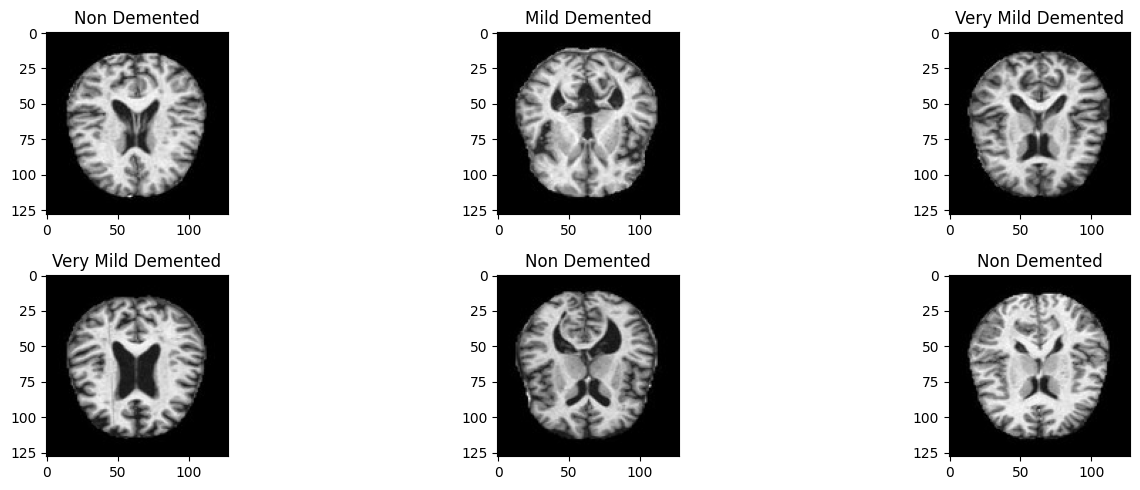

In [ ]:


# Sample the data to avoid memory issues (taking 6 random images and their labels)
sample_data = train_df.select("label", "img_arr").limit(6).collect()

# Convert the sample data to a format suitable for plotting
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
axs = ax.flatten()

# Loop through the axes and display images
for i, axes in enumerate(axs):
    # Get a random image and label from the sample
    row = sample_data[i]
    img_arr = np.array(row['img_arr']).reshape(128, 128)  # Assuming images are 128x128
    label = row['label']

    # Plot the image
    axes.imshow(img_arr, cmap="gray")
    axes.set_title(LABELS.get(label, "Unknown"))

plt.tight_layout()
plt.show()


**11. Visualizing Label Distribution**

The label distribution is plotted using a bar chart. Color-coded bars correspond to the categories in the LABELS dictionary.
Provides insight into the dataset's class balance, as it is shown the dataset is imbalanced, which can lead to biased models that perform poorly on underrepresented classes.

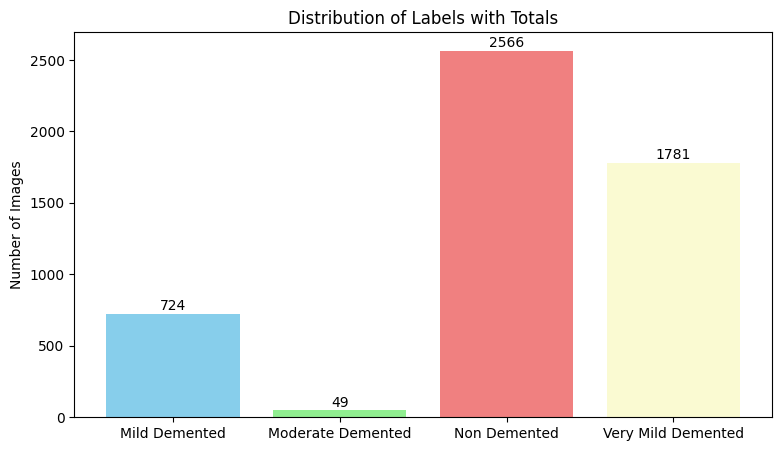

In [ ]:
# Count the occurrences of each label in the 'label' column using Spark
label_counts = train_df.groupBy("label").count().orderBy("label")

# Convert the Spark DataFrame to Pandas for easy plotting
label_counts_pd = label_counts.toPandas()

# Define a color map for each label
label_colors = {
    0: 'skyblue',        # Mild Demented
    1: 'lightgreen',     # Moderate Demented
    2: 'lightcoral',     # Non Demented
    3: 'lightgoldenrodyellow'  # Very Mild Demented
}

# Plotting the bar chart with colors for each label
plt.figure(figsize=(9, 5))
bars = plt.bar(label_counts_pd['label'], label_counts_pd['count'],
               color=[label_colors[label] for label in label_counts_pd['label']])

# Add totals above each bar
for bar, count in zip(bars, label_counts_pd['count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f"{count}", ha='center', va='bottom')

# Customize the plot
plt.ylabel("Number of Images")
plt.xticks(np.arange(0, 4, 1), labels=[LABELS[i] for i in range(4)])
plt.title("Distribution of Labels with Totals")
plt.show()


# **2.Feature Extraction and Visualization**

### **1. Feature Extraction:**
The extract_features function creates new columns for statistical features:

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql.functions import mean, stddev, max, min, col, expr
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Extraction
def extract_features(df):
    # Check if 'features' column already exists
    if 'features' not in df.columns:  # Only add features if it doesn't exist
        # Extract simple statistical features from images
        df = df.withColumn("mean", expr("aggregate(img_arr, 0D, (acc, x) -> acc + x) / size(img_arr)"))  # Calculate mean using aggregate function
        df = df.withColumn("std", expr("sqrt(aggregate(img_arr, 0D, (acc, x) -> acc + (x - mean) * (x - mean)) / (size(img_arr) - 1))").alias("std"))  # Calculate standard deviation
        df = df.withColumn("max", expr("array_max(img_arr)"))  # Calculate max
        df = df.withColumn("min", expr("array_min(img_arr)"))  # Calculate min

        # Assemble features into a vector
        assembler = VectorAssembler(inputCols=["mean", "std", "max", "min"], outputCol="features")
        df = assembler.transform(df)
    return df # Return the DataFrame, modified or not

This function calculates the mean, standard deviation, maximum, and minimum values of each image's pixel array. It then assembles these features into a vector column named "features".

### **2. Apply Feature Extraction:**

The function is applied to both training and test datasets.

In [ ]:
# Apply feature extraction
train_df = extract_features(train_df)
test_df = extract_features(test_df)


### **3. Feature Correlation Visualization:**
This code creates a correlation matrix of the extracted features and visualizes it using a heatmap. This helps identify relationships between different statistical properties of the images.

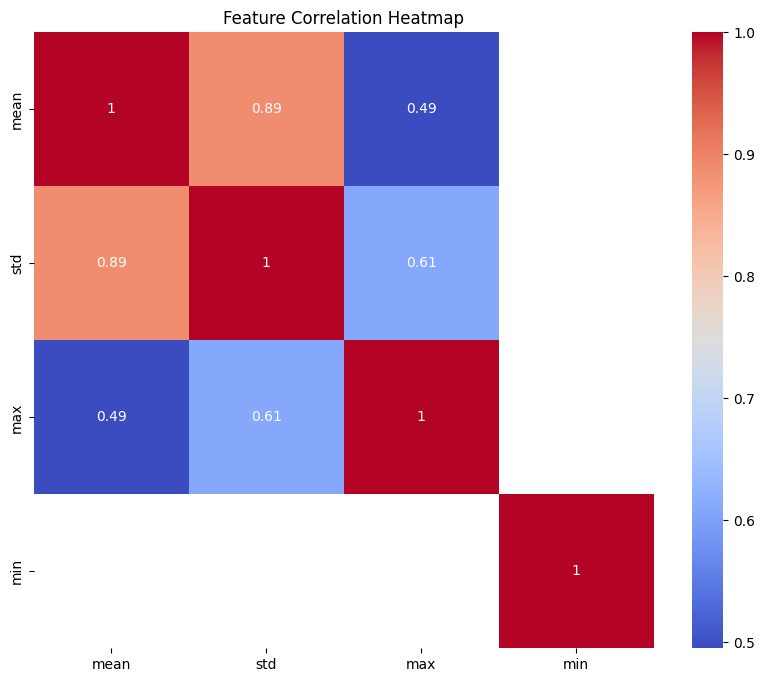

In [ ]:
feature_cols = ["mean", "std", "max", "min"]
# Select the 'features' column along with the other feature columns
feature_df = train_df.select("features", *feature_cols)
correlation_matrix = Correlation.corr(feature_df, "features").collect()[0][0].toArray()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=feature_cols, yticklabels=feature_cols)
plt.title("Feature Correlation Heatmap")
plt.show()

### **4. Feature Distribution Visualization:**
For each extracted feature (mean, std, max, min), it creates a histogram with a kernel density estimate (KDE) curve to show the distribution shape. This helps understand the distribution of each feature across the dataset.

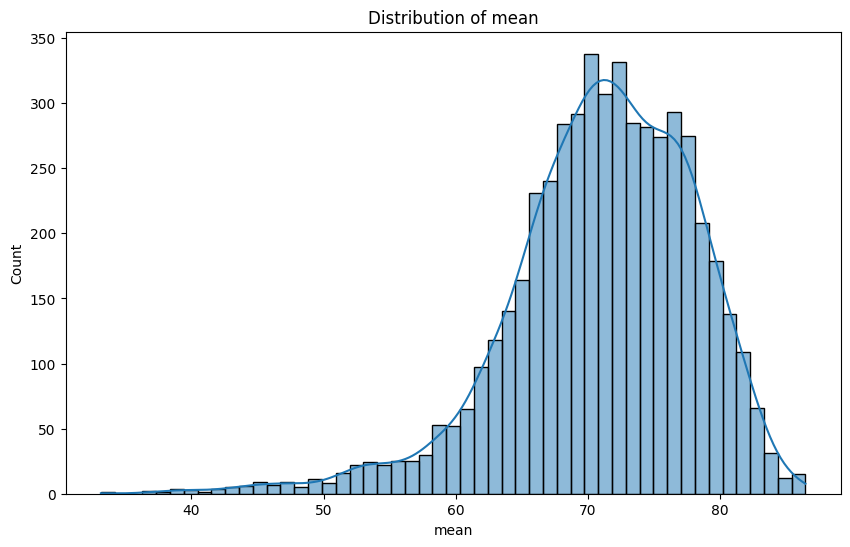

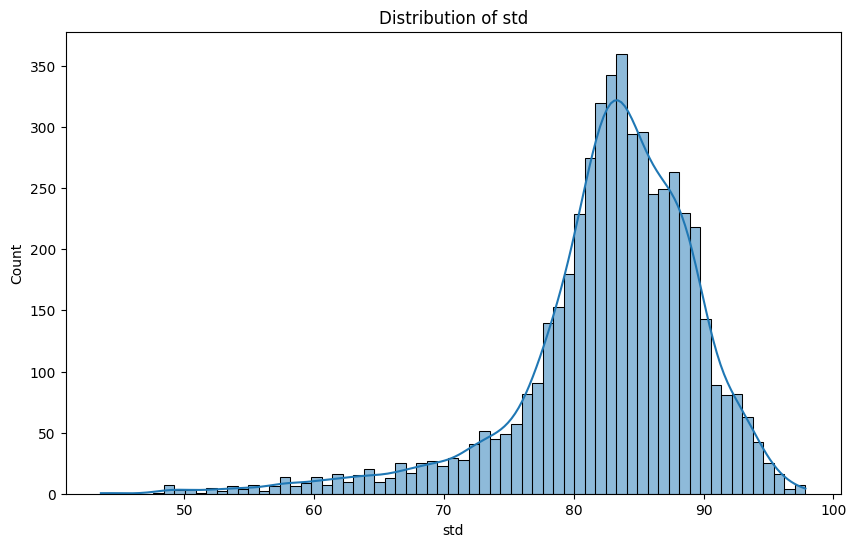

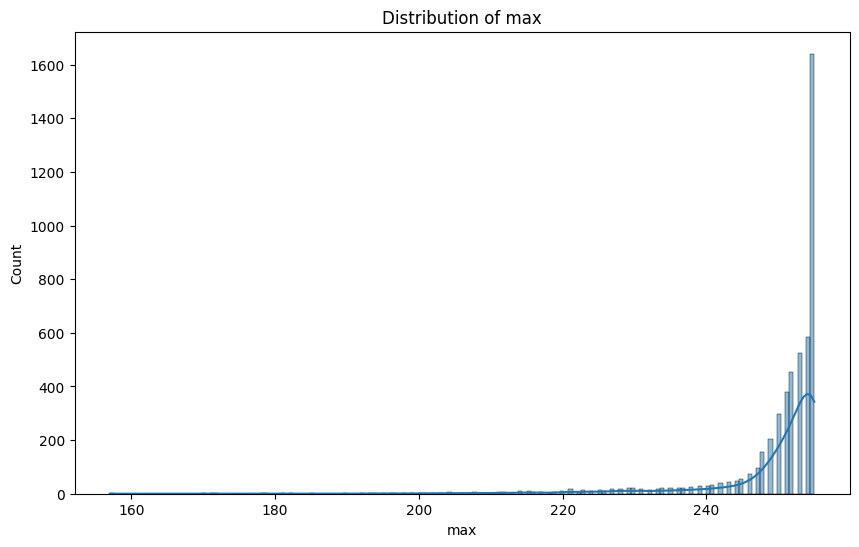

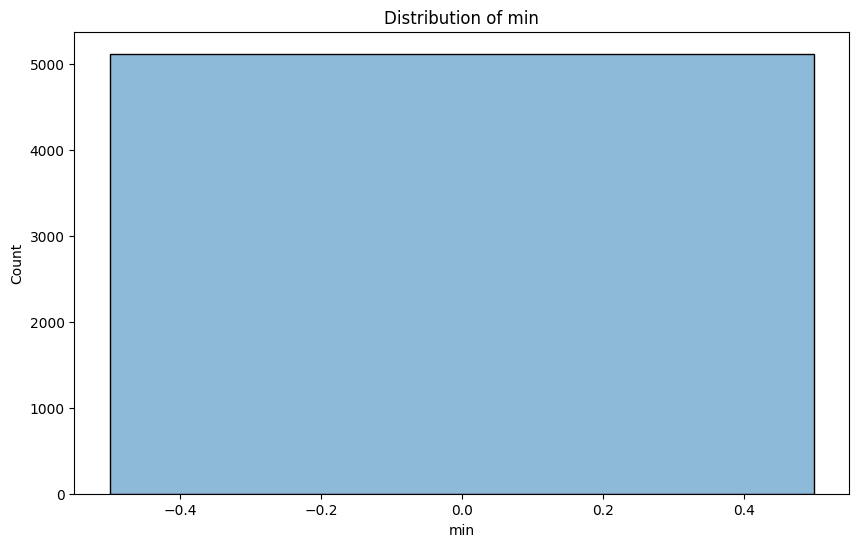

In [ ]:
for feature in feature_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=train_df.select(feature).toPandas(), x=feature, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.show()